In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, REINDEX_CHANNELS_AR
from torch.utils.data import DataLoader
from hmpai.data import SAT1_STAGES_ACCURACY, AR_STAGES
import scipy

### Load datasets

In [2]:
set_global_seed(42)
data_path = Path("../data/ar/split_stage_data.nc")
dataset = xr.load_dataset(data_path)

In [3]:
# Re-order channels to be as similar as possible to SAT1
dataset = dataset.reindex(channels=REINDEX_CHANNELS_AR).drop_sel(
    channels=["trash1", "trash2"]
)
# Labels in both SAT1 and AR
common_labels = list(set(SAT1_STAGES_ACCURACY).intersection(set(AR_STAGES)))
dataset = dataset.sel(labels=common_labels)

In [7]:
# dataset = dataset.isel(samples=slice(None, 161))

In [4]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_min1_to_1
)
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological)
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological)
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological)

In [5]:
chk_path = Path("../models/gru100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [45]:
chk_path = Path("../models/cnn100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
model = SAT1Base(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

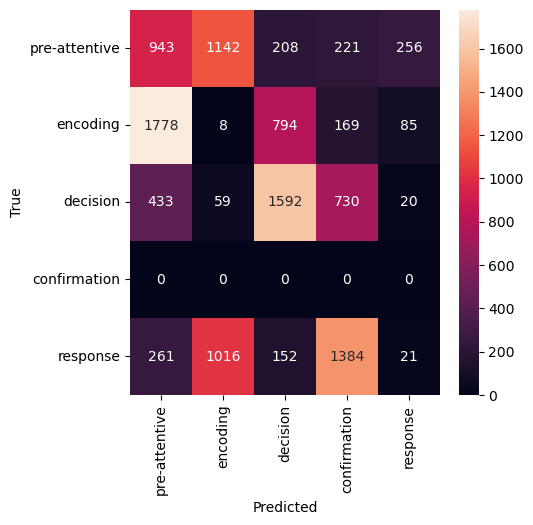

In [7]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY)

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(true, pred)

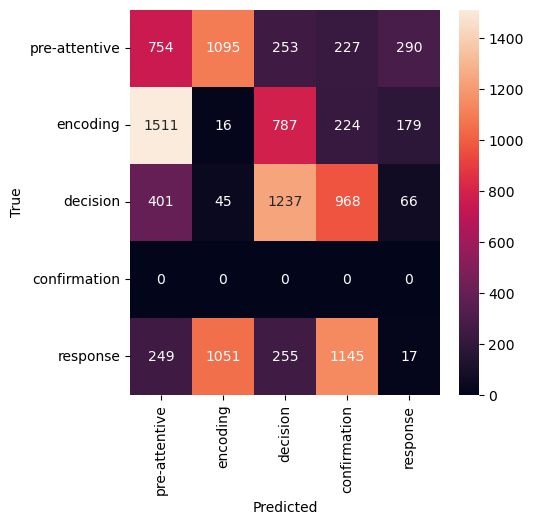

In [51]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(0.5, 5.5), labels=SAT1_STAGES_ACCURACY, rotation=90)
plt.yticks(ticks=np.arange(0.5, 5.5), labels=SAT1_STAGES_ACCURACY, rotation=0)
plt.show()

In [ ]:
test_loader.__next__()